# Artificial Neural Networks and Deep Learning    
## Assignment 3.1 - Autoencoders and Stacked Autoencoders

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement two network architectures from scratch: (1) Autoencoders; (2) Stacked Autoencoders.

We will train both networks on the MNIST dataset under reconstruction learning task. All training will be conducted on a single T4 GPU.


In [ ]:
# Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
# !nvidia-smi

# Autoencoder
In this section, we implement an Autoencoder from scratch and trainit on the MNIST dataset. With this autoencoder, we pass input data through an encoder making a compressed representation of the input, and then pass this representation to the following decoder to reconstruct the input data.
Note that in this exercise session we will be using  ``PyTorch`` instead of ``Keras`` for building and training our neural networks.


In [1]:
from pathlib import Path
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

FIGURE_PATH = Path("../report/figures")

# Set the seed for reproducibility. Don't forget to comment out this line when averaging over different runs
torch.manual_seed(42)

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Select only a part of the dataset to speed up training times
num_train_samples = 10000
num_test_samples = 1000

# Randomly select a subset of samples
train_indices = torch.randperm(len(train_data))[:num_train_samples]
test_indices = torch.randperm(len(test_data))[:num_test_samples]

# Create subset samplers to be used in the dataloader
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)



## Create training and test dataloaders


Dataloaders are used for efficiently loading, batching, and managing datasets in PyTorch.
During training dataloaders feed the data into the network batch by batch instead of the whole dataset at once. This allows us to handle larger datasets without running out of memory.

In [2]:
# Choose how many samples per batch to load
# You can tune the batch size
batch_size = 32

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_subset_sampler,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          sampler = test_subset_sampler,
                                          num_workers=0)


## Visualize the data

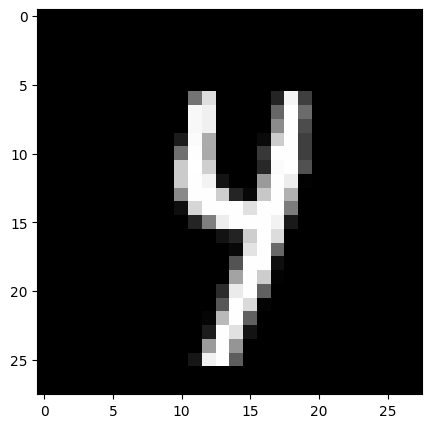

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
images, labels = next(iter(train_loader)) # iter() creates an iterator over the batches in the dataloader and next() selects the next batch from this iterator.
images = images.numpy() #.numpy() turns the torch.tensor into a numpy array

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Build the Linear Autoencoder
We now train a linear autoencoder on MINIST dataset.
Images of original size 28$\times$28 will be flattened into 784-dimensional vectors.
Note that images from this dataset are already normalized so that the values are between 0 and 1.
Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

The encoder and decoder in the Autoencoder are built with one linear layer where you can tune the dimension of the hidden representation, i.e., ``encoding_dim``, to obtain models with different size.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(784, encoding_dim)
        # Decoder
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        # Define feedforward behavior
        # and scale the *output* layer with a sigmoid activation function

        # Pass x into encoder
        out = F.relu(self.encoder(x))
        # Pass out into decoder
        out = torch.sigmoid(self.decoder(out))

        return out

In [5]:
# Initialize the NN
# You can change the encoding_dim to obtain models with different size
encoding_dim = 32
model = Autoencoder(encoding_dim)

# Send model to GPU if available
if torch.cuda.is_available():
  model.cuda()
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)


## Training on MNIST
Training a neural network in PyTorch involves manually defining the training loop.
Here data processing, forward pass, loss computation, and optimization are explicitly specified.

Since we work on reconstruction learning tasks, we do not need the labels here but only the images.
The loss function should choose the MSE loss for reconstruction.

In [6]:
# Specify the loss function
criterion = nn.MSELoss()

# We use Adam as the optimizer with a fixed learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Choose the number of Epochs to train the network
n_epochs = 20
# Set model to training mode
model.train()

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Train the model #
    # Feed the data into the network batch by batch using the dataloader
    for batch_data in train_loader:
        # _ stands in for labels
        # we do not need labels when conducting reconstruction
        images, _ = batch_data
        # Flatten images and send images to GPU
        images = images.view(images.size(0), -1)
        # Send images to GPU if possible
        if torch.cuda.is_available():
          images = images.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*images.size(0)

    # Print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))




Epoch: 0 	Training Loss: 2.386593
Epoch: 1 	Training Loss: 1.315528
Epoch: 2 	Training Loss: 1.040680
Epoch: 3 	Training Loss: 0.878057
Epoch: 4 	Training Loss: 0.759522
Epoch: 5 	Training Loss: 0.688439
Epoch: 6 	Training Loss: 0.636693
Epoch: 7 	Training Loss: 0.597742
Epoch: 8 	Training Loss: 0.568476
Epoch: 9 	Training Loss: 0.546332
Epoch: 10 	Training Loss: 0.530176
Epoch: 11 	Training Loss: 0.518377
Epoch: 12 	Training Loss: 0.509132
Epoch: 13 	Training Loss: 0.501971
Epoch: 14 	Training Loss: 0.495893
Epoch: 15 	Training Loss: 0.491787
Epoch: 16 	Training Loss: 0.488524
Epoch: 17 	Training Loss: 0.485783
Epoch: 18 	Training Loss: 0.483460
Epoch: 19 	Training Loss: 0.480828


## Evaluation on test set
We now evaluate the reconstruction results on the unseen test set.
We plot the original test images and their corresponding reconstruction ones.

In [7]:
# Set model to evaluation mode
model.eval()

# Monitor test loss
test_loss = 0.0

# Disable gradient computation
with torch.no_grad():
    # Iterate over the test data
    for batch_data in test_loader:
        # Extract images from the batch
        images, _ = batch_data
        # Flatten images and send them to GPU
        images = images.view(images.size(0), -1)
        # Send to GPU
        if torch.cuda.is_available():
          images = images.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Update test loss
        test_loss += loss.item()*images.size(0)

# Compute average test loss
test_loss = test_loss/len(test_loader.dataset)

# Print test loss
print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 0.001470


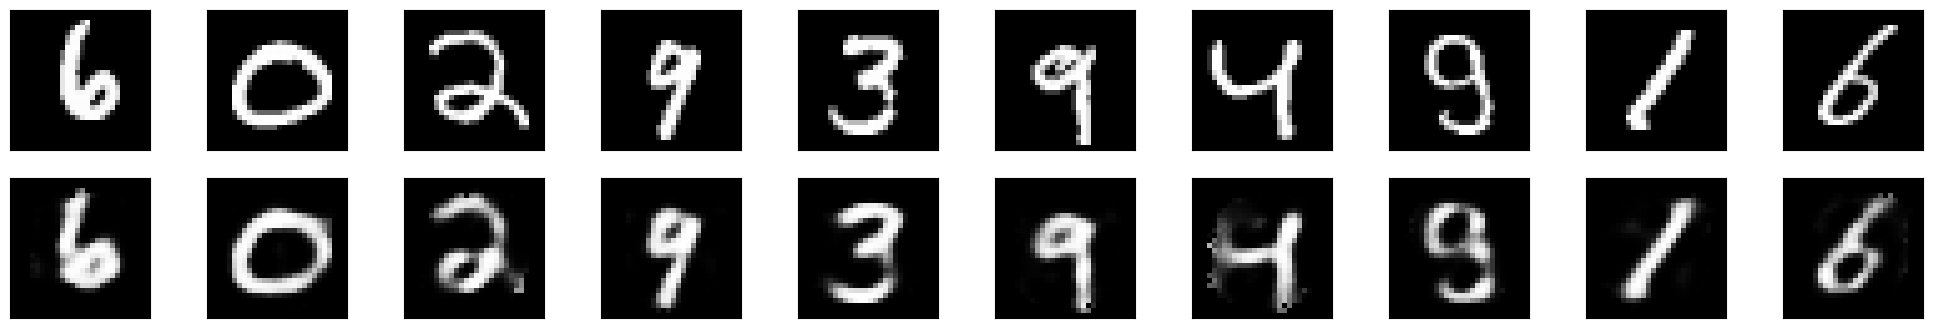

In [8]:
# Obtain one batch of test images
test_images, test_labels = next(iter(test_loader))

test_images_flatten = test_images.view(test_images.size(0), -1)
# Set model to evaluation mode
model.eval()
# Send model back to CPU
model.cpu()
# Get sample outputs
output = model(test_images_flatten)
# Prep images for display
test_images = test_images.numpy()

# Output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for test_images, row in zip([test_images, output], axes):
    for img, ax in zip(test_images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Stacked Autoencoder
In this section, we implement the Stacked Autoencoder from scratch and train it on the MNIST dataset.
The training process is with two steps: (1) each layer is trained separately; (2) the network is trained as a whole.

We first load the dataset as follows:

In [3]:
import torch
from torch import nn, optim, functional, utils

from torch.nn import BCELoss, init
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import time, os

# We automate the dataloading process for future use
def get_mnist_loader(batch_size=32, num_train_samples = 6000, num_test_samples = 1000):
		"""

    :return: train_loader, test_loader
    """

		transform = transforms.Compose([
		transforms.ToTensor(),  # Convert image to PyTorch tensor
		transforms.Normalize((0.0,), (1.0,))  # Normalize the tensor with mean 0 and standard deviation 1
		])
		train_dataset = MNIST(root='../data',
													train=True,
													transform=transform,
													download=True)
		test_dataset = MNIST(root='../data',
													train=False,
													transform=transform,
													download=True)

		# Randomly select a subset of samples
		train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
		test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

		# Create subset samplers to be used in the dataloader
		train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
		test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

		train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
																								batch_size=batch_size,
																								sampler = train_subset_sampler)
		test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
																							batch_size=batch_size,
																							sampler = test_subset_sampler)
		return train_loader, test_loader

## Build the Stacked Autoencoder
Before building the Stacked Autoencoder, we need to build the Autoencoder layer first.

In [10]:
class AutoEncoderLayer(nn.Module):
    """
    fully-connected linear layers for stacked autoencoders.
    This module can automatically be trained when training each layer is enabled
    Yes, this is much like the simplest auto-encoder
    """

    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()
        # If input_dim is None or hidden_dim is None:
        # raise ValueError
        self.in_features = input_dim
        self.out_features = hidden_dim
        # Whether to conduct layer-by-layer pre-training, or train the entire network
        self.is_training_self = SelfTraining
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.Sigmoid(),  # use Sigmoid activation function
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True), nn.Sigmoid()
        )
        # self._initialize_weights()

    def forward(self, x):
        out = self.encoder(x)
        if self.is_training_self:
            return self.decoder(
                out
            )  # If the layer is not in training mode, it will just encode the data and pass it through
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

## Build the stacked autoencoder

Here we stack the autoencoder layers together and add a classification layer at the end

In [11]:
class StackedAutoEncoderClassifier(nn.Module):
    """
    Stack the trained autoencoder layers and add a classification layer at the end
    """

    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()
        # Use only the encoder parts of the autoencoders
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # Classification layer
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


## The training function of each layer
We need to freeze the parameters in the previous layers when training the current layer.

In [39]:
def train_layer(layers_list=None, layer=None, epochs=None, validate=True, batch_size = 128, losses=[]):
    """
    Greedy layer-wise training: when training the i-th layer, freeze the i-1 layer
    :param layers_list:
    :param layer:
    :param epoch:
    :return:
    """
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size)
    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Train
    for epoch_index in range(epochs):
        sum_loss = 0.

        # Freeze the parameters of all layers before the current layer
        # Layer 0 has no previous layer
        if layer != 0:
            for index in range(layer):
                # In addition to freezing parameters
                # the output return method of the frozen layer must also be set.
                layers_list[index].lock_grad()
                layers_list[index].is_training_layer = False

        for batch_index, (train_data, _) in enumerate(train_loader):
            # Generate input data
            if torch.cuda.is_available():
                train_data = train_data.cuda()  # Put data onto GPU
            out = train_data.view(train_data.size(0), -1)

            # Perform forward calculation on the frozen layers before (layer-1)-th layer
            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            # Train the layer-th layer
            pred = layers_list[layer](out)

            optimizer.zero_grad()
            loss = criterion(pred, out)
            sum_loss += loss
            loss.backward()
            optimizer.step()
            #if (batch_index + 1) % 20 == 0:
        print("Train Layer: {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))
        losses.append(loss)

        if validate:
            pass

## The training function of the whole network
Now we unfreeze all the parameters in the network that are previously frozen for the layer training.

In [40]:
def train_classifier(model=None, epochs=20, fine_tuning = False, batch_size = 128, losses=[]):

    print(">> start training whole model")
    if torch.cuda.is_available():
        model.cuda()

    # unfreeze the parameters frozen in pre-training if needed
    if fine_tuning:
      for param in model.parameters():
          param.requires_grad = True
      training_phase = 'Fine-Tuning'
    else:
      training_phase = 'Classifier'

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size)
    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    # train
    for epoch_index in range(epochs):
        sum_loss = 0.
        for batch_index, (train_data, train_labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data, train_labels = train_data.cuda(), train_labels.cuda()
            x = train_data.view(train_data.size(0), -1)

            predicted_labels = model(x)

            optimizer.zero_grad()
            loss = criterion(predicted_labels, train_labels)
            sum_loss += loss
            loss.backward()
            optimizer.step()

        print("Train {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(training_phase, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))
        losses.append(loss)
        
    print("<< end training whole model")
    print("Calculating accuracy on the whole test set")

    # Set model to evaluation mode
    model.eval()

    # Calculate accuracy on the test set
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch_data in test_loader:
            images, labels = batch_data
            images = images.view(images.size(0), -1)
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # Get the highest value for each point to get the label
            _, predicted_labels = torch.max(outputs.data, 1)
            # Count number of correct predictions in the batch
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)


    # Compute average test loss
    accuracy = total_correct / total_samples
    print('Accuracy on the test set: {:.6f}'.format(accuracy))
    return model, accuracy


## Let's start training!
The default network is trained with layer epochs 10, classifier epochs 10, fine-tuning epochs 20, batch size of 128. You can try to change the hyper-parameters to obtain better reconstruction performance.

In [54]:
# You can change the hyper-parameters here
# Be sure to try out different combinations of epochs for the pretraining and fine-tuning
num_layer_wise_epochs = 20
num_classifier_epochs = 30
num_finetuning_epochs = 50
batch_size = 128

In [61]:
input_dim = 784
hidden_dim1 = 256
hidden_dim2 = 64
# Define the autoencoder layers
# Try different values for the dimensions of the hidden layers and the number of layers
encoder_1 = AutoEncoderLayer(input_dim = input_dim, hidden_dim = hidden_dim1, SelfTraining=True)
encoder_2 = AutoEncoderLayer(input_dim = hidden_dim1, hidden_dim = hidden_dim2, SelfTraining=True)

encoders_list = [encoder_1, encoder_2]
num_layers = len(encoders_list)
losses = []

# Pre-train each layer
for level in range(num_layers):
   train_layer(layers_list=encoders_list, layer=level, epochs=num_layer_wise_epochs, validate=True, batch_size = batch_size, losses=losses)

# Build the stacked autoencoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoders_list, num_classes = 10)
# Print the model
print(SAE_model)

# First train the classification layer
train_classifier(model=SAE_model, epochs=num_classifier_epochs, fine_tuning = False, batch_size = batch_size, losses=losses)

# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model, epochs=num_finetuning_epochs, fine_tuning = True, batch_size = batch_size, losses=losses)


# Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)
torch.save(SAE_model, './models/sae_model.pt')

Train Layer: 0, Epoch: 1/20, Iter: 47/47, Loss: 0.2233
Train Layer: 0, Epoch: 2/20, Iter: 47/47, Loss: 0.2088
Train Layer: 0, Epoch: 3/20, Iter: 47/47, Loss: 0.1963
Train Layer: 0, Epoch: 4/20, Iter: 47/47, Loss: 0.1839
Train Layer: 0, Epoch: 5/20, Iter: 47/47, Loss: 0.1737
Train Layer: 0, Epoch: 6/20, Iter: 47/47, Loss: 0.1638
Train Layer: 0, Epoch: 7/20, Iter: 47/47, Loss: 0.1548
Train Layer: 0, Epoch: 8/20, Iter: 47/47, Loss: 0.1467
Train Layer: 0, Epoch: 9/20, Iter: 47/47, Loss: 0.1395
Train Layer: 0, Epoch: 10/20, Iter: 47/47, Loss: 0.1321
Train Layer: 0, Epoch: 11/20, Iter: 47/47, Loss: 0.1267
Train Layer: 0, Epoch: 12/20, Iter: 47/47, Loss: 0.1227
Train Layer: 0, Epoch: 13/20, Iter: 47/47, Loss: 0.1167
Train Layer: 0, Epoch: 14/20, Iter: 47/47, Loss: 0.1121
Train Layer: 0, Epoch: 15/20, Iter: 47/47, Loss: 0.1095
Train Layer: 0, Epoch: 16/20, Iter: 47/47, Loss: 0.1054
Train Layer: 0, Epoch: 17/20, Iter: 47/47, Loss: 0.1017
Train Layer: 0, Epoch: 18/20, Iter: 47/47, Loss: 0.0990
T

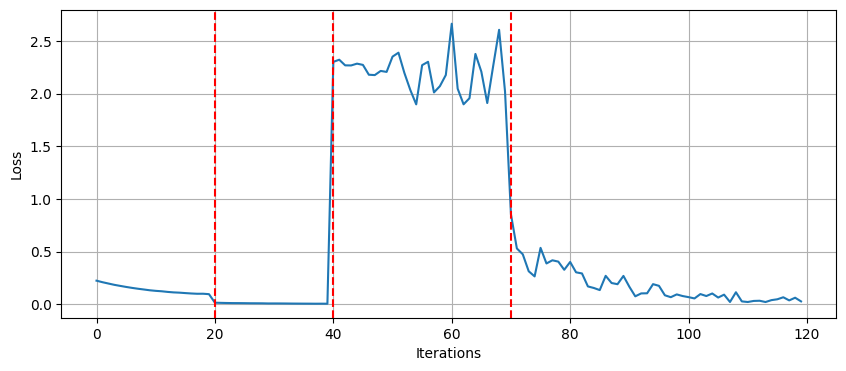

In [65]:
from pathlib import Path
FIGURE_PATH = Path("../report/figures")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot([i for i in range(len(losses))], [float(loss) for loss in losses])
# Vertical lines to indicate the end of pre-training and fine-tuning
plt.axvline(x=num_layer_wise_epochs, color='r', linestyle='--')
plt.axvline(x=num_layer_wise_epochs * 2, color='r', linestyle='--')
plt.axvline(x=num_layer_wise_epochs * 2 + num_classifier_epochs, color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(FIGURE_PATH / "ex3_1_loss.pdf", bbox_inches='tight')
plt.show()